Добрый день.

Многоклассовая классификация

1. загрузите из sklearn датасет с цифрами (каждый элемент кодирует изображение цифры размером 8х8)
2. Осмотрите данные и метки.
3. попробуйте отобразить любое единичное изображение из набора с помощью matplotlib.
4. Примените тетрадку с прошлого урока к загруженному датасету в части многоклассовой классификации. 
5. Рассмотрите матрицу неточностей, сделайте выводы какие цифры классификатор принимает за другие наиболее часто.
6. Сравните качество стратегий OvR и OvO.


Логистическая регрессия

1. Возьмите датасет с данными по телефонной компании с прошлых уроков.
2. Подготовьте данные для обучения.
3. Нормализуйте данные с помощью MinMaxScaler (рассматривали в конце прошлого урока)
4. Обучите логистическую регрессию на нормированных данных.
5. Посчитайте метрики на тестовом и обучающем множествах.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import confusion_matrix, precision_score, \
              recall_score, f1_score

Загрузим данные.

In [100]:
data = load_digits()

In [101]:
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [102]:
data.data.shape

(1797, 64)

Данные представлят собой словарь с ключами.
 - data - сами данные. Матрица. 1797 строк. 64 столбца. В строку выписаны по порядку значения из сетки начиная с первой строки. 
 Само изоржение однослойное  таком случае.
 - target - вектор знчений. Содержит "ответ" - то, что закодировано в изображении
 - images - трехмерный массив изображений. содержит 1797 матриц 8*8.

По другим ключам по существу интересного ничего нет...

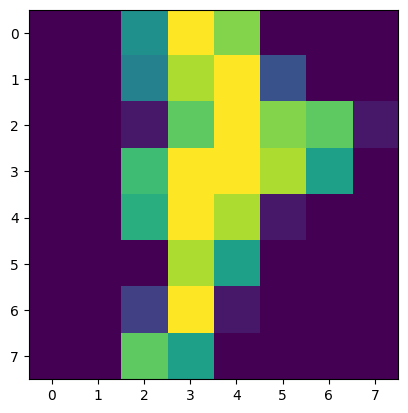

In [103]:
plt.imshow(data.images[211]);

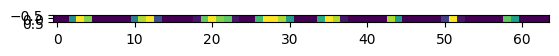

In [104]:
plt.imshow(data.data[211].reshape(1, -1));

In [105]:
data.target[211]

7

Слабо похоже, но это 7...

<AxesSubplot:>

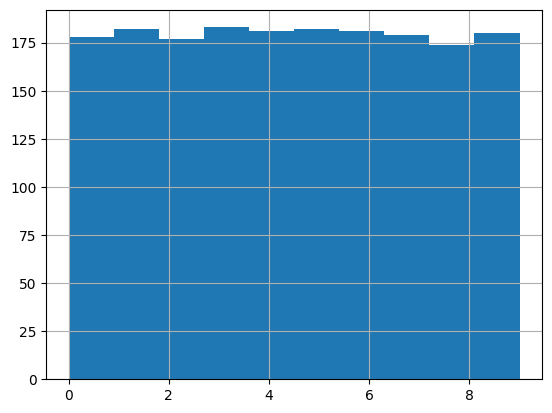

In [106]:
pd.Series(data.target).hist()

Все данные валидны и их много. Перекоса в классах у нас нет, что также хорошо

Разделим на тренировочную и тестовую выборки в соотношении 80/20.

In [107]:
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.8, random_state=1)

Поработаем с этими данными многоклассовым классификатором SGD с применением стратегий OvO и OvR.

In [108]:
ovoSGD = OneVsOneClassifier(SGDClassifier(random_state=1))
ovrSGD = OneVsRestClassifier(SGDClassifier(random_state=1))

In [109]:
ovoSGD.fit(x_train, y_train)
ovrSGD.fit(x_train, y_train);

Вычислим точность обоих классификаторов

In [110]:
ovoSGD.score(x_test, y_test), ovrSGD.score(x_test, y_test)

(0.9123783031988874, 0.9290681502086231)

In [111]:
ovo_pred, ovr_pred = ovoSGD.predict(x_test), ovrSGD.predict(x_test)

Результат немного лучше у OvR классификатора.

Вычислим precision, recall и f1 скор

In [112]:
precision_score(y_test, ovo_pred, average = 'macro'), recall_score(y_test, ovo_pred, average = 'macro'), f1_score(y_test, ovo_pred, average = 'macro') 

(0.9177022020442983, 0.9127177906946363, 0.9134691745994008)

In [113]:
precision_score(y_test, ovr_pred, average = 'macro'), recall_score(y_test, ovr_pred, average = 'macro'), f1_score(y_test, ovr_pred, average = 'macro') 

(0.9335074283376649, 0.9303748763557012, 0.9304718643638772)

Снова же все результаты у OvR классификатора лучше

Посмотрим на матрицу неточностей. Сразу занулим главную диагональ. Она не информативна, т.к. точность у классификаторов довольно высокая.

In [114]:
ovo_cm, ovr_cm = confusion_matrix(y_test, ovo_pred), confusion_matrix(y_test, ovr_pred)
np.fill_diagonal(ovo_cm, 0)
np.fill_diagonal(ovr_cm, 0)

Опытным путём установлено (при передаче функции аргумента labels), что подписи соответствуют самим числам, а в документации сказано, что по вертикали в шапке записаны предсказания модели, а по горозинтали - истинные значения.

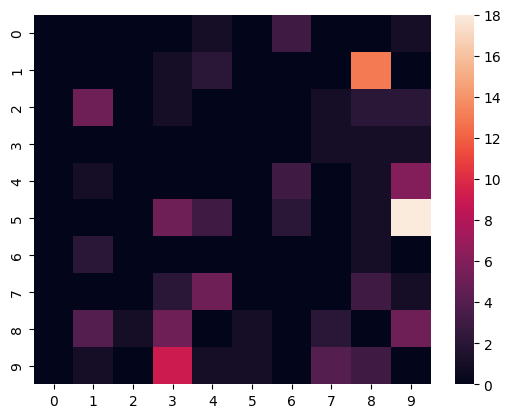

In [115]:
sns.heatmap(ovo_cm);

In [116]:
ovo_cm

array([[ 0,  0,  0,  0,  1,  0,  3,  0,  0,  1],
       [ 0,  0,  0,  1,  2,  0,  0,  0, 13,  0],
       [ 0,  5,  0,  1,  0,  0,  0,  1,  2,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1],
       [ 0,  1,  0,  0,  0,  0,  3,  0,  1,  6],
       [ 0,  0,  0,  5,  3,  0,  2,  0,  1, 18],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  2,  5,  0,  0,  0,  3,  1],
       [ 0,  4,  1,  5,  0,  1,  0,  2,  0,  5],
       [ 0,  1,  0,  9,  1,  1,  0,  4,  3,  0]], dtype=int64)

Опишем три самых ярких пятна на тепловой матрице:

1. В 18 случаях модель давала предсказние 9 при факте 5.
2. В 13 случаях модель давала предсказние 8 при факте 1.
3. В 9 случаях модель давала предсказние 3 при факте 9.

In [117]:
ovr_cm

array([[ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  3,  0,  0,  0, 10,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  0,  4,  0],
       [ 0,  1,  1,  0,  0,  0,  0,  1,  9,  1],
       [ 0,  3,  0,  0,  0,  0,  2,  1,  1,  2],
       [ 1,  1,  0,  2,  0,  0,  0,  1,  1,  7],
       [ 0,  4,  0,  0,  1,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  2,  3,  0,  0,  0,  1,  1],
       [ 0,  4,  0,  1,  1,  0,  0,  0,  0,  1],
       [ 2,  5,  0,  2,  0,  0,  0,  3,  8,  0]], dtype=int64)

У OvR классификатора ошибок ожидаемо меньше. Хотя он стал больше ошибаться и давать ответ 8 при факте 9.

В целом классификатор OvR дал лучший результат.